In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import pygeohash
import folium
import math
from matplotlib import pyplot as plt

def create_bins(df, col, span):
    re = df.copy()
    re[col+'_bin'] = re[col].apply(lambda x: int(math.floor(x/span)*span))
    return re

# Exploration & Analysis
Now we analyze the results to see look for correlations at intersesctions:
* Road Speeds
* Road Widths
* Lane Counts

In [2]:
crime_df = pd.read_json('./prepared_data/crash_data.json', orient='records')
intersection_df = pd.read_json('./prepared_data/intersection_info.json', orient='records') 
data_df = pd.read_json('./prepared_data/prepared_data.json', orient='records')

In [71]:
intersection_df['MTO_owned'] = intersection_df['owners'].apply(lambda x: 1 if 'MTO' in x  and ('ROH' in x or 'COB' in x) else 0)
data_df['MTO_owned'] = data_df['owners'].apply(lambda x: 1 if 'MTO' in x  and ('ROH' in x or 'COB' in x) else 0)
data_df['speed_delta'] = data_df['max_speed_limit'] - data_df['min_speed_limit']
intersection_df['speed_delta'] = intersection_df['max_speed_limit'] - intersection_df['min_speed_limit']

First we'll find the number of intersections with certain values for normalization later.

In [72]:
stats = dict()
stats_cols = ['max_width', 'min_width', 'max_speed_limit', 'min_speed_limit', 'max_lanes', 'min_lanes', 'min_width_to_lane_ratio', 'max_width_to_lane_ratio', 'speed_delta', 'MTO_owned']
for col in stats_cols:
    stats[col] = intersection_df[col].value_counts()
stats_cols_bin = {
    10: ['max_width', 'min_width'],
    3: ['min_width_to_lane_ratio', 'max_width_to_lane_ratio']
}
for key, value in stats_cols_bin.items():
    for col in value:
        stats[col + '_bin'] = create_bins(intersection_df, col, key)[col+'_bin'].value_counts()


## Road Speeds

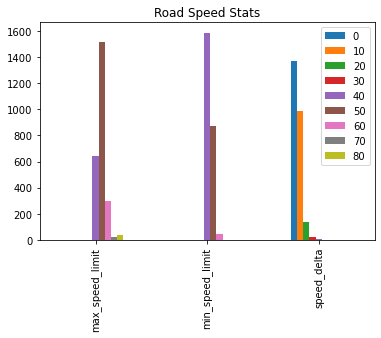

In [45]:
pd.DataFrame([stats['max_speed_limit'], stats['min_speed_limit'], stats['speed_delta']]).sort_index().plot.bar()
plt.title("Road Speed Stats")
plt.show()

In [48]:
pd.DataFrame([stats['max_speed_limit'], stats['min_speed_limit'], stats['speed_delta']])

,0,10,20,30,40,50,60,70,80
max_speed_limit,NaN,NaN,1.0,NaN,641.0,1519.0,298.0,21.0,37.0
min_speed_limit,NaN,NaN,3.0,1.0,1586.0,876.0,47.0,1.0,3.0
speed_delta,1369.0,984.0,137.0,20.0,7.0,NaN,NaN,NaN,NaN


From the table above, we can see that certain speeds are rarely seen at intersections. 30 km/h, for example, isn't a speed used on any City or Regional owned roads in Burlington. We'll need to keep this in mind for this analysis. 

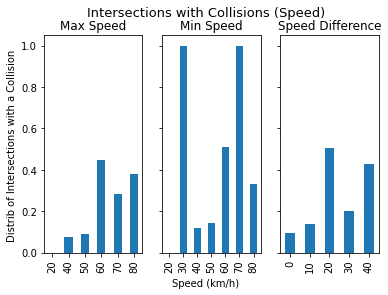

In [40]:
# Is there a collision?
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True)
(data_df[['max_speed_limit', 'geohash']].drop_duplicates()['max_speed_limit'].value_counts()/stats['max_speed_limit']).plot.bar(ax=axes[0])
axes[0].title.set_text('Max Speed')
(data_df[['min_speed_limit', 'geohash']].drop_duplicates()['min_speed_limit'].value_counts()/stats['min_speed_limit']).plot.bar(ax=axes[1])
axes[1].title.set_text('Min Speed')
(data_df[['speed_delta', 'geohash']].drop_duplicates()['speed_delta'].value_counts()/stats['speed_delta']).plot.bar(ax=axes[2])
axes[2].title.set_text('Speed Difference')
fig.text(0.04, 0.5, 'Distrib of Intersections with a Collision', va='center', rotation='vertical')
fig.text(0.5, 0.01, 'Speed (km/h)', ha='center')
fig.suptitle("Intersections with Collisions (Speed)", fontsize=13)
plt.show()

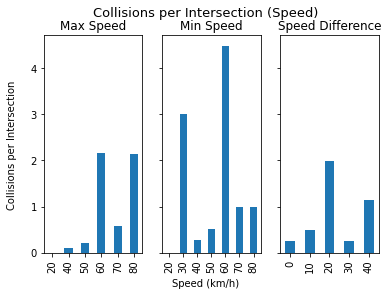

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True)
(data_df[['max_speed_limit', 'geohash']]['max_speed_limit'].value_counts()/stats['max_speed_limit']).plot.bar(ax=axes[0])
axes[0].title.set_text('Max Speed')
(data_df[['min_speed_limit', 'geohash']]['min_speed_limit'].value_counts()/stats['min_speed_limit']).plot.bar(ax=axes[1])
axes[1].title.set_text('Min Speed')
(data_df['speed_delta'].value_counts()/stats['speed_delta']).plot.bar(ax=axes[2])
axes[2].title.set_text('Speed Difference')
fig.text(0.04, 0.5, 'Collisions per Intersection', va='center', rotation='vertical')
fig.text(0.5, 0.01, 'Speed (km/h)', ha='center')
fig.suptitle("Collisions per Intersection (Speed)", fontsize=13)
plt.show()

If the anomolies were to be ignored, it could be assumed that as the maximum or minimum speed increases for an intersection, the higher the number of collisions. In order to avoid instances where the minimum speed is one of the outliers (e.g. 30km/h, 20km/h), we'll use the `max_speed_limit` field in combination with the `speed_delta` field when creating a model.

## Road Widths

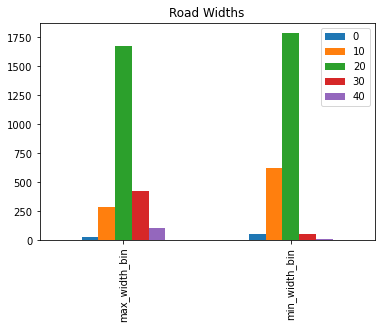

In [7]:
# Max and Min Width Distribution
pd.DataFrame([stats['max_width_bin'], stats['min_width_bin']]).sort_index().plot.bar()
plt.title("Road Widths")
plt.show()

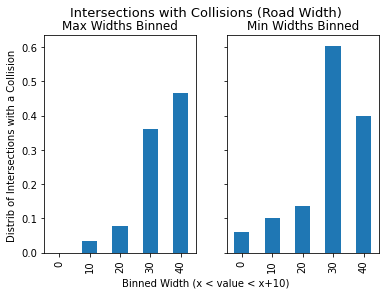

In [8]:
# Is there a collision?
max_width_binned = create_bins(data_df[['max_width', 'geohash']].drop_duplicates(), 'max_width', 10)
min_width_binned = create_bins(data_df[['min_width', 'geohash']].drop_duplicates(), 'min_width', 10)
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
(max_width_binned['max_width_bin'].value_counts()/stats['max_width_bin']).plot.bar(ax=axes[0])
axes[0].title.set_text("Max Widths Binned")
(min_width_binned['min_width_bin'].value_counts()/stats['min_width_bin']).plot.bar(ax=axes[1])
axes[1].title.set_text("Min Widths Binned")
del max_width_binned
del min_width_binned
fig.text(0.04, 0.5, 'Distrib of Intersections with a Collision', va='center', rotation='vertical')
fig.text(0.5, 0.01, 'Binned Width (x < value < x+10)', ha='center')
fig.suptitle("Intersections with Collisions (Road Width)", fontsize=13)
plt.show()

Despite intersections with max widths between 40 and 50 metres making up a minority, there a disproportionately large number of these intersections have collisions. \
Regarding min widths, more intersections at 30 to 50 metres have collisions than expected.

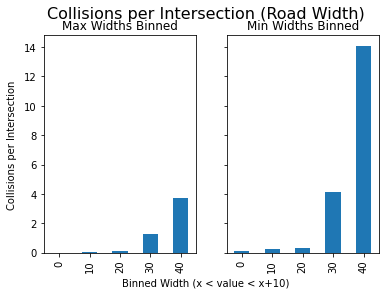

In [9]:
# Collisions per intersection
max_width_binned = create_bins(data_df[['max_width', 'geohash']], 'max_width', 10)
min_width_binned = create_bins(data_df[['min_width', 'geohash']], 'min_width', 10)
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
(max_width_binned['max_width_bin'].value_counts()/stats['max_width_bin']).plot.bar(ax=axes[0])
axes[0].title.set_text("Max Widths Binned")
(min_width_binned['min_width_bin'].value_counts()/stats['min_width_bin']).plot.bar(ax=axes[1])
axes[1].title.set_text("Min Widths Binned")
del max_width_binned
del min_width_binned
fig.text(0.04, 0.5, 'Collisions per Intersection', va='center', rotation='vertical')
fig.suptitle("Collisions per Intersection (Road Width)", fontsize=16)
fig.text(0.5, 0.01, 'Binned Width (x < value < x+10)', ha='center')
plt.show()

As expected, there are also a higher collisions per intersection the wider the width of the intersecting roads. 

## Lane Counts

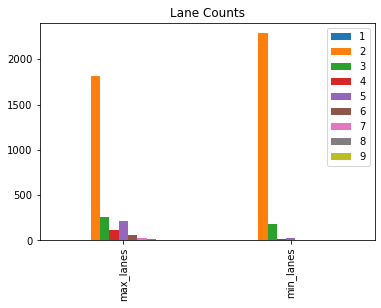

In [10]:
pd.DataFrame([stats['max_lanes'], stats['min_lanes']]).sort_index().plot.bar()
plt.title("Lane Counts")
plt.show()

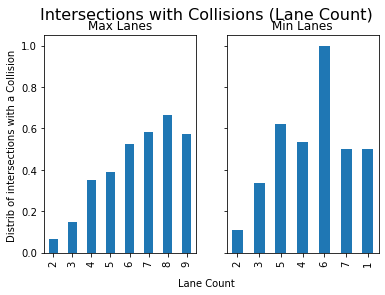

In [11]:
# Is there a collision?
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
(data_df[['max_lanes', 'geohash']].drop_duplicates()['max_lanes'].value_counts()/stats['max_lanes']).plot.bar(ax=axes[0])
axes[0].title.set_text("Max Lanes")
(data_df[['min_lanes', 'geohash']].drop_duplicates()['min_lanes'].value_counts()/stats['min_lanes']).plot.bar(ax=axes[1])
axes[1].title.set_text("Min Lanes")
fig.text(0.04, 0.5, 'Distrib of intersections with a Collision', va='center', rotation='vertical')
fig.suptitle("Intersections with Collisions (Lane Count)", fontsize=16)
fig.text(0.5, 0.01, 'Lane Count', ha='center')
plt.show()

Despite so few intersections having a high number of max lanes, a larger proportion of them have had a motor vehicle collision. A pattern is less evident when looking at the minimum number of lanes.

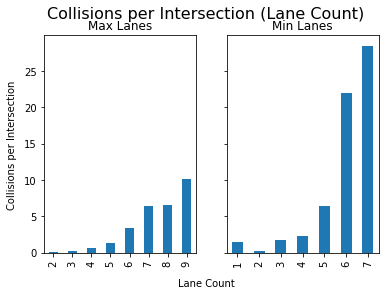

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
(data_df[['max_lanes', 'geohash']]['max_lanes'].value_counts()/stats['max_lanes']).plot.bar(ax=axes[0])
axes[0].title.set_text("Max Lanes")
(data_df[['min_lanes', 'geohash']]['min_lanes'].value_counts()/stats['min_lanes']).plot.bar(ax=axes[1])
axes[1].title.set_text("Min Lanes")
fig.text(0.04, 0.5, 'Collisions per Intersection', va='center', rotation='vertical')
fig.text(0.5, 0.01, 'Lane Count', ha='center')
fig.suptitle("Collisions per Intersection (Lane Count)", fontsize=16)
plt.show()

A pattern is more consistent when you look at the number of collisions per intersection, where those with a higher number of lanes have a higher distribution of collisions.

## Width to Lane Ratio

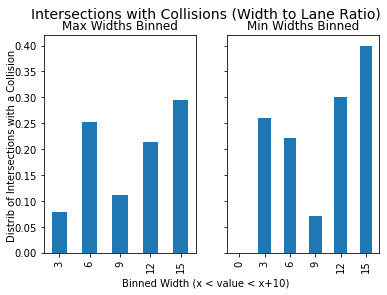

In [13]:
# Is there a collision?
max_width_per_lane = create_bins(data_df[['max_width_to_lane_ratio', 'geohash']].drop_duplicates(), 'max_width_to_lane_ratio', 3)
min_width_per_lane = create_bins(data_df[['min_width_to_lane_ratio', 'geohash']].drop_duplicates(), 'min_width_to_lane_ratio', 3)
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
(max_width_per_lane['max_width_to_lane_ratio_bin'].value_counts()/stats['max_width_to_lane_ratio_bin']).plot.bar(ax=axes[0])
axes[0].title.set_text("Max Widths Binned")
(min_width_per_lane['min_width_to_lane_ratio_bin'].value_counts()/stats['min_width_to_lane_ratio_bin']).plot.bar(ax=axes[1])
axes[1].title.set_text("Min Widths Binned")
del max_width_per_lane
del min_width_per_lane
fig.text(0.04, 0.5, 'Distrib of Intersections with a Collision', va='center', rotation='vertical')
fig.text(0.5, 0.01, 'Binned Width (x < value < x+10)', ha='center')
fig.suptitle("Intersections with Collisions (Width to Lane Ratio)", fontsize=14)
plt.show()

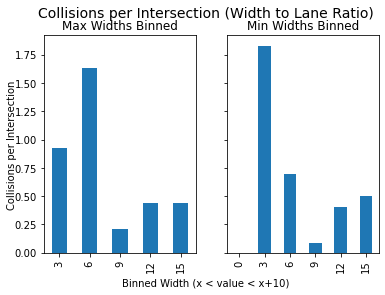

In [14]:
# Is there a collision?
max_width_per_lane = create_bins(data_df[['max_width_to_lane_ratio', 'geohash']], 'max_width_to_lane_ratio', 3)
min_width_per_lane = create_bins(data_df[['min_width_to_lane_ratio', 'geohash']], 'min_width_to_lane_ratio', 3)
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
(max_width_per_lane['max_width_to_lane_ratio_bin'].value_counts()/stats['max_width_to_lane_ratio_bin']).plot.bar(ax=axes[0])
axes[0].title.set_text("Max Widths Binned")
(min_width_per_lane['min_width_to_lane_ratio_bin'].value_counts()/stats['min_width_to_lane_ratio_bin']).plot.bar(ax=axes[1])
axes[1].title.set_text("Min Widths Binned")
del max_width_per_lane
del min_width_per_lane
fig.text(0.04, 0.5, 'Collisions per Intersection', va='center', rotation='vertical')
fig.text(0.5, 0.01, 'Binned Width (x < value < x+10)', ha='center')
fig.suptitle("Collisions per Intersection (Width to Lane Ratio)", fontsize=14)
plt.show()

It's difficult to identify any pattern when looking at width-to-lane ratio (which can be interpreted as the average lane width). Ratios as high as 15m show that the `actual_width` of the streets do not only include the roadway, but likely include the sidewalks, boulevards, etc.\
We will not be using this ratio explicitly to create the model. It is also possible that the model finds this relationship on its own.

## Bonus: Ministry of Transportation of Ontario (MTO) Influence
We'll use this to see if intersections owned by the Ministry of Transportation of Ontario (MTO) are more prone to collisions. We won't be using this data as we're focusing on the influence of the design of the road. However, it can be hypothesized that MTO-owned infrastructure is more dangerous due to their design standards. All intersections marked as MTO owned intersect with municipal roads.

In [73]:
print(f"There are {(data_df['MTO_owned'] == 1).sum()} out of {data_df.shape[0]} collisions at intersections that are MTO_Owned")
print(f"and {(intersection_df['MTO_owned'] == 1).sum()} out of {intersection_df.shape[0]} intersections are MTO_Owned")

There are 96 out of 1103 collisions at intersections that are MTO_Owned
and 58 out of 2517 intersections are MTO_Owned


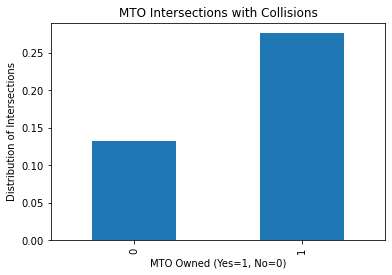

In [74]:
(data_df[['MTO_owned', 'geohash']].drop_duplicates()['MTO_owned'].value_counts()/stats['MTO_owned']).plot.bar()
plt.xlabel("MTO Owned (Yes=1, No=0)")
plt.ylabel("Distribution of Intersections")
plt.title("MTO Intersections with Collisions")
plt.show()

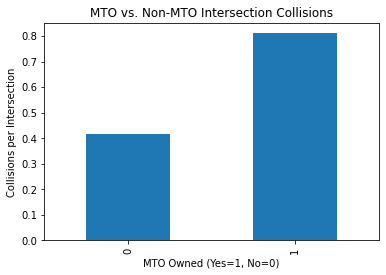

In [66]:
(data_df[['MTO_owned', 'geohash']]['MTO_owned'].value_counts()/stats['MTO_owned']).plot.bar()
plt.xlabel("MTO Owned (Yes=1, No=0)")
plt.ylabel("Collisions per Intersection")
plt.title("MTO vs. Non-MTO Intersection Collisions")
plt.show()

MTO owned infrastructure has a higher number of collisions per intersection compared to non-MTO owned ones. Similarly can be observed when looking at the distribution of MTO Intersections with Collisions, where a quarter of them have reported crashes. It's important to note that very few (58 according to the data) intersections are owned by MTO. For a deeper dive either:
- more data would be needed
- the model created predicts road designs that align with MTO highway standards are more dangerous

# Model Variables
The following variables will be used to create the model:
* `max_speed`
* `speed_delta`
* `max_lanes`

Previous professional experience in this area has shown that weather has minimal impact on the potential of a collision and therefore will not be included.\

## Possible Others
These variables either aren't readily available via OpenData or were not generated as part of the initial iteration of this project.
* **Road Geometry**: Future models could make use of data relating to the geometry of the approaching road, such as the number of and degree of bends it has.
* **Traffic Controls**: the existance stop signs or traffic signals could decrease (or even increase sometimes) the chance of a collision. Right-on-red is known to increase the chance of collisions, this information could be useful as well
* **Turning Lanes**: The number of turning lanes could be an indication of the design of the intersection.
* **Turning Radius**: The curb radius at an intersection influences that speed at which a driver will turn. Higher speeds, combined with Right-on-red and large turning radii could result in more collisions.